In [ ]:
# Load necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from google.colab import files
import os

Load the data

In [ ]:
# Upload kaggle.json file
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"subhiksha28","key":"e5adf35b3106a20a86b05635875de03d"}'}

In [ ]:
# Install and setup Kaggle CLI
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download and unzip the Sentiment140 dataset
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:03<00:00, 30.8MB/s]
100% 80.9M/80.9M [00:03<00:00, 23.5MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
# Load the dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)

# Assign column names
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

In [ ]:
#Info of the dataset
print('length of data is', len(df))

length of data is 1600000


In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

#Check for missing values
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,0
target,0
id,0
date,0
flag,0
user,0
text,0


Sampling

In [ ]:
# Separate positive and negative samples
positive_samples = df[df['target'] == 4] # Assuming 4 represents positive sentiment
negative_samples = df[df['target'] == 0] # Assuming 0 represents negative sentiment

# Sample an equal number of positives and negatives
n_samples = 100000
positive_sampled = positive_samples.sample(n=n_samples, random_state=1)
negative_sampled = negative_samples.sample(n=n_samples, random_state=1)

# Combine and shuffle the samples
senti140_reduced = pd.concat([positive_sampled, negative_sampled]).sample(frac=1, random_state=1).reset_index(drop=True)
print("Balanced dataset created with {} positive and {} negative samples.".format(n_samples, n_samples))

Balanced dataset created with 100000 positive and 100000 negative samples.


In [ ]:
# Keep only the 'target' and 'text' columns
senti140_reduced = senti140_reduced[['target', 'text']]
senti140_reduced.head()

,target,text
0,4,"@kosmonaut huh hot wings from mac tacos, not b..."
1,0,Don't like ending the night arguing with the ...
2,4,"i got a bruise on my leg ughh but GOd yeay, ca..."
3,4,Media PDP did not get done =(. some more songs...
4,4,"well, no more school until the first day of sc..."


Pre-processing

In [ ]:
# Text preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

# Define the text cleaning Regex
TEXT_CLEANING_RE = "@\w+|https?://\S+|[^A-Za-z0-9]+"
# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Pre-process function
def preprocess(text):
    # Remove link, user, and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(lemmatizer.lemmatize(token))
    return " ".join(tokens)

# Apply preprocessing to the text data
senti140_reduced['text'] = senti140_reduced['text'].apply(preprocess)
print("Preprocessing completed.")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Preprocessing completed.


In [ ]:
senti140_reduced.head()

,target,text
0,4,huh hot wing mac taco burrito
1,0,like ending night arguing huz smf stupid home ...
2,4,got bruise leg ughh god yeay cant wait church
3,4,medium pdp get done song added last fm account...
4,4,well school first day school september


Splitting the data

In [ ]:
# Split the data
X = senti140_reduced['text']
y = senti140_reduced['target'].apply(lambda x: 1 if x == 4 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SVM

In [ ]:
# Prepare data for SVM
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Train SVM model
svm_model = svm.SVC(probability=True)
svm_model.fit(X_train_tfidf, y_train)

SVC(probability=True)

In [ ]:
# Predict and use SVM probabilities as input features for LSTM
svm_train_prob = svm_model.predict_proba(X_train_tfidf)[:, 1]
svm_test_prob = svm_model.predict_proba(X_test_tfidf)[:, 1]

LSTM

In [ ]:
# Tokenize text for LSTM
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_sequence_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [ ]:
# Combine SVM probabilities with padded sequences
X_train_combined = np.hstack((svm_train_prob.reshape(-1, 1), X_train_pad))
X_test_combined = np.hstack((svm_test_prob.reshape(-1, 1), X_test_pad))

In [ ]:
# Build the LSTM model
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Input(shape=(X_train_combined.shape[1],)))
model.add(Embedding(vocab_size, embedding_dim,
                    input_length=max_sequence_length + 1))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Train the LSTM model
history = model.fit(X_train_combined, y_train, epochs=5, batch_size=256,
                    validation_split=0.1, verbose=1)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 112s 196ms/step - accuracy: 0.6999 - loss: 0.5679 - val_accuracy: 0.7653 - val_loss: 0.4867
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 107s 190ms/step - accuracy: 0.8026 - loss: 0.4343 - val_accuracy: 0.7626 - val_loss: 0.4869
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 104s 185ms/step - accuracy: 0.8296 - loss: 0.3838 - val_accuracy: 0.7570 - val_loss: 0.5016
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 104s 185ms/step - accuracy: 0.8474 - loss: 0.3483 - val_accuracy: 0.7524 - val_loss: 0.5208
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 102s 182ms/step - accuracy: 0.8613 - loss: 0.3144 - val_accuracy: 0.7520 - val_loss: 0.5681


In [ ]:
# Model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 101, 50)             │       3,609,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,011,355 (42.00 MB)

 Trainable params: 3,670,451 (14.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,340,904 (28.00 MB)

Evaluation

In [ ]:
# Evaluate the model
y_pred = (model.predict(X_test_combined) > 0.5).astype("int32")
print("Accuracy:", accuracy_score(y_test, y_pred))

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step
Accuracy: 0.753375


In [ ]:
#Generate a classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75     19822
           1       0.75      0.76      0.76     20178

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000



Visulizations

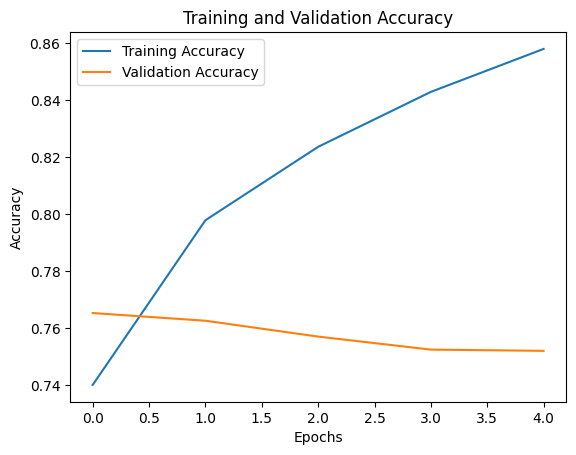

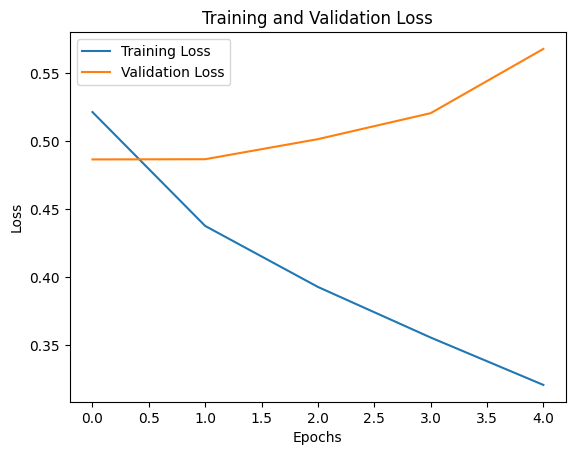

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

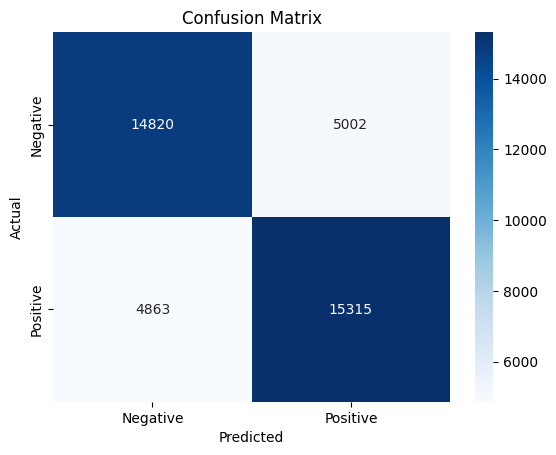

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step


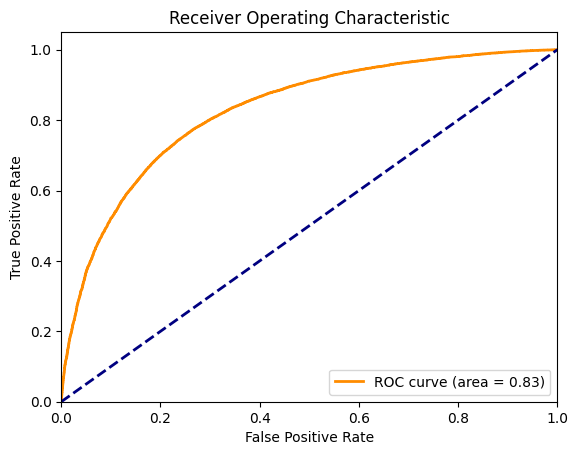

In [ ]:
# Compute ROC curve and AUC for each class
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test_combined))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()